In [101]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [406]:

class controller_obj():
    def __init__(self, master_sort_mat):
        # init things here
        self.horizon = 30
        
        self.num_materials = 3
        self.belt_length = 62
        self.volume_length = 2
        self.speed_control_ratio = 0.2
        self.num_speeds = 4
        
        self.speed_min = 0.7
        self.speed_max = 1.33
        self.item_0_start_id = 10
        self.item_0_end_id = 15
        self.item_1_start_id = 25
        self.item_1_end_id = 30
        self.picks_per_sec = 1.5
        self.update_rate = 12
        self.num_volumes = int(self.belt_length/self.volume_length)
        self.state_dim = self.num_materials * self.num_volumes + 1
        
        self.iters = 10
        self.armijo_iters = 10
        self.armijo_backtrack = 0.5
        self.delta = 0.05
        self.learning_rate = 0.05
        self.prices = np.array([0.306, 0.124, 0.01875]) #units here are cents/unit.  PET: 12.25 c/lb, PP: 5.5 c/lb, 3-7 bale 0.75 c/lb 40 pc/lb
        # self.prices = np.array([1, 0.001, 0.00001875]) #units here are cents/unit.  PET: 12.25 c/lb, PP: 5.5 c/lb, 3-7 bale 0.75 c/lb 40 pc/lb
        
        
        self.A = self.generate_A_matrix()
        
        self.B = np.zeros((self.state_dim))
        self.B[-1] = self.speed_control_ratio
        
        self.picks = []
        self.cum_sorts = 0
        self.U_traj_last = np.ones((self.horizon))

        
        
        # print(self.master_sort_mat)
        pick_width_0 = self.item_0_end_id - self.item_0_start_id
        picks_0 = []
        for i in range(pick_width_0):
            picks_0.append(self.item_0_start_id + i)

        self.picks.append(picks_0)
        
        pick_width_1 = self.item_1_end_id - self.item_1_start_id
        picks_1 = []
        for i in range(pick_width_1):
            picks_1.append(self.item_1_start_id + i)
            
        self.picks.append(picks_1)
        
        
        
    def generate_A_matrix(self):
        A = np.zeros((self.state_dim, self.state_dim, self.num_speeds))
        
        for speed in range(self.num_speeds):
            for i in range((self.num_volumes-speed)*self.num_materials):
                A[i+(speed * self.num_materials), i,  speed] = 1
            for j in range(speed):
                for i in range(self.num_materials):
                    A[j*self.num_materials + i, i, speed] = 1
            A[-1, -1, speed] = 1-self.speed_control_ratio
            
        return A
        
    def state_callback(self, data):

        
        state = data.data
        start = rospy.get_rostime().to_sec()
        
        U_traj_opt = self.solve_opt_traj(state, self.U_traj_last)
        self.U_traj_last = np.copy(U_traj_opt)
        pub_u_traj.publish(U_traj_opt.astype(np.float32))

        return
  
    def solve_opt_traj(self, x_init, U_traj_init):
        debug = 0
        
        U_traj_nom = np.ones(self.horizon) * x_init[-1]
        U_traj_nom[:-1] = np.copy(U_traj_init[1:])
        U_traj_nom[-1] = np.copy(U_traj_init[-1])
        grad = np.zeros_like(U_traj_nom)
        deltas = self.delta * np.diag(np.ones_like(U_traj_nom))
        lr = self.learning_rate
        
        base_score = self.rollout(x_init, U_traj_nom)
        # print('base score: ', base_score)
        eye_traj = np.eye(self.horizon)
        converged = False
        B_new = np.eye(self.horizon)
        # calcualte gradient:
        for i in range(self.iters):
            for dir in range(self.horizon):
                s = self.rollout(x_init, (U_traj_nom + deltas[dir]))
                grad[dir] = (s-base_score)/self.delta
        
        # if first step, do gradient descent:
            j = 0
            if i == 0:
                debug = 1
                update = lr * grad
                # print('grad descent')
            # otherwise do BFGS step
            else:
                # print('\n\n trying bfgs \n')
                y = (grad - last_grad)
                del_x = np.copy(last_step)
                y = y[:, np.newaxis]
                del_x = del_x[:, np.newaxis]

                if np.all(y !=0 ) and np.any(del_x != 0):
                    term1 = np.eye(self.horizon) - ((del_x @ y.T)/(y.T@del_x))
                    term2 = np.copy(last_B)
                    term3 = np.eye(self.horizon) - ((y@del_x.T)/(y.T@del_x))
                    term4 = ((del_x @ del_x.T)/(y.T @ del_x))
                  
                    B_new = np.abs(term1 @ term2 @ term3 + term4)
                    update = B_new @ grad
                    # print('update from bfgs: ', update)
                    debug = 3    
                # print('bfgs')
                else:
                    debug = 2
                    update = lr * grad
                    B_new = np.eye(self.horizon)
            
            
            #armijo rule backtracking line search
            # print('update', update)
            # print('grad', grad)
            # U_traj_hyp = U_traj_nom - update
            # U_traj_hyp_clipped = U_traj_hyp.clip(self.speed_min, self.speed_max)
            # update = U_traj_hyp_clipped - U_traj_nom
            
            # U_traj_hyp = np.copy(U_traj_hyp_clipped)
            # hyp_score = self.rollout(x_init, U_traj_hyp)
            # print(hyp_score)
            for attempt in range(self.armijo_iters):
                
                # print('armijo: ', attempt)
                U_traj_hyp = U_traj_nom + update
                # print('update1: ', update)
                U_traj_hyp_clipped = U_traj_hyp.clip(self.speed_min, self.speed_max)
                update = U_traj_hyp_clipped - U_traj_nom 
                # print('update2: ', update)
                U_traj_hyp = np.copy(U_traj_hyp_clipped)
                hyp_score = self.rollout(x_init, U_traj_hyp)
                # print('hyp score armijo: ', format(hyp_score, '.2e'))
                # print('u_traj_hyp: ', U_traj_hyp)
                # print('update: ', update)
                
                if hyp_score > base_score:
                    debug =4
                    break
                elif hyp_score == base_score:   
                    converged = True
                    debug = 5
                    break
                elif attempt + 1 < self.armijo_iters:
                    update *= self.armijo_backtrack
                    debug = 6
                else: 
                    debug = 7
                    update = lr * grad
                    # U_traj_hyp = U_traj_nom
                    break
                   
                    
                 
            last_B = np.copy(B_new)
            last_grad = np.copy(grad)
            last_step = U_traj_hyp - U_traj_nom
            
            if np.all(np.abs(last_step) <= 0.000000001):
                # print('hit conv crit')
                converged = True
            base_score = hyp_score
            # print('score: ', base_score)
            # print('u_traj: ', U_traj_hyp)
            U_traj_nom = np.copy(U_traj_hyp)
            # print('debug = ', debug)
            # print('update: ', update)
            # print('gradient: ', grad)
            if converged == True:
                break            
        # print('done solving')
        return U_traj_nom
    
    def rollout(self, x, U_traj):
        
        X_traj = np.zeros((self.horizon + 1, self.state_dim))
        score = 0
        
        
        
        for step in range(self.horizon):
            if step == 0:
                
                A_rollout, sort_mat = self.rollout_linearize_A(x)
                X_traj[step] = A_rollout @ x + self.B * U_traj[step]
            else:
                A_rollout, sort_mat = self.rollout_linearize_A(X_traj[step-1])
                X_traj[step] = A_rollout @ X_traj[step - 1] + self.B * U_traj[step]

            score += self.get_state_cost(X_traj[step], sort_mat, step+1)
            
        
        A_rollout, sort_mat = self.rollout_linearize_A(X_traj[self.horizon-1])
        X_traj[self.horizon] = A_rollout @ X_traj[self.horizon-1] + self.B * U_traj[self.horizon-1]
        
        score += self.get_state_cost(X_traj[self.horizon], sort_mat, self.horizon)
            
        
        return score
    
    def rollout_linearize_A(self, x):
        
        sort_vec = np.zeros((self.state_dim))
        floor = np.floor(x[-1])
        ceil = floor + 1
        ratio = x[-1] - floor
        A = self.A[:, :, int(floor)] * (1-ratio) + self.A[:, :, int(ceil)] * ratio
        sort_mat = np.zeros((self.state_dim, len(self.picks)))
        # print(np.shape(sort_mat))
        # print(np.shape(sort_mat[:,0]))
        
        for mat in range(len(self.picks)):
            for idx, i in enumerate(self.picks[mat]):
                sort_vec[i*self.num_materials + mat] = 1
            if sort_vec.T @ x > self.picks_per_sec / self.update_rate:
                # print('triggered! ', sort_vec.T @ x)
                sort_vec *= (self.picks_per_sec/self.update_rate)/(sort_vec.T @ x)
                # print(' new sort vec: ', sort_vec)
            sort_mat[:, mat] = sort_vec
            # print('sort_vec: ', sort_vec)
            # print('sort_mat: ', sort_mat)
            A = A * (np.ones((self.state_dim)) - sort_vec)
        
        
        return A, sort_mat

    def get_state_cost(self, x, sort_mat, discount, verbose=False, eval = False):

        positive_sort_price_vec = sort_mat @ self.prices[:-1]
        positive_sort_val = positive_sort_price_vec @ x
        
       
        
        negative_sort_price_vec = np.zeros((self.state_dim))
        negative_sort_price_vec[(self.num_volumes-1)*self.num_materials : self.num_volumes*self.num_materials] = self.prices[-1]
        negative_sort_val = negative_sort_price_vec @ x

        # negative_sort_val = 0
        
        missed_opportunity_vec = (master_sort_mat-sort_mat) @ (self.prices[-1] - self.prices[:-1])
        missed_opportunity_val = missed_opportunity_vec @ x
        if eval:
            missed_opportunity_val = 0

        if verbose:
            print('\n---------------------------------------\npositive sort val: ', positive_sort_val)
            print('potisive sort price vec: ', positive_sort_price_vec)
            print('x, ', x)
            print('negative sort val: ', negative_sort_val)
            
            print('missed opportunity val: ', missed_opportunity_val)
        
        return (positive_sort_val + negative_sort_val + missed_opportunity_val)/discount

    def one_step_fwd(self, x, U_traj):
        A_lin, _ = self.rollout_linearize_A(x)
        x_next = A_lin @ x + self.B * U_traj[0]
        return x_next
        
    def cash_aht(self, x, verbose = False, eval = False):
        _, sort_mat = self.rollout_linearize_A(x)
        return self.get_state_cost(x, sort_mat, 1, verbose, eval)
        
C = controller_obj(master_sort_mat)        
 

In [373]:
master_sort_mat

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

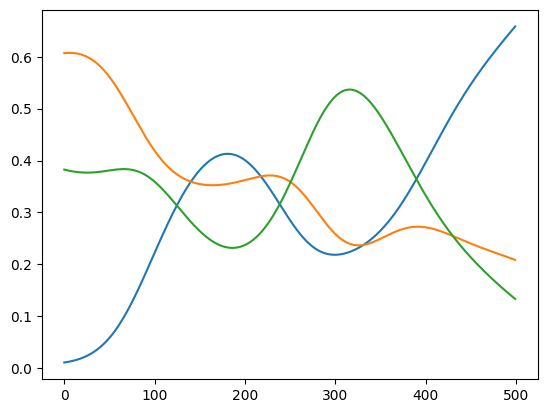

In [413]:
## generate infeed array
n_materials = 3

log_time = 500

infeed = np.ones((log_time, n_materials))

num_hits = 10
x = np.arange(0, log_time, 1)

hits_1 = np.random.randint(0, log_time, num_hits)
hits_2 = np.random.randint(0, log_time, num_hits)
hits_3 = np.random.randint(0, log_time, num_hits)


hit_inds = np.random.randint(0, log_time, (num_hits, n_materials))
for hit in range(num_hits):
    for i in range(n_materials):
        infeed[:, i] += scipy.stats.norm.pdf(x, hit_inds[hit, i], 50)*10000
        

infeed_norm = np.sum(infeed, axis=1, keepdims=True)

infeed = infeed/infeed_norm

plt.plot(infeed[:, 0])
plt.plot(infeed[:, 1])
plt.plot(infeed[:, 2])


# generate infeed, plot it in this cell


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 5673.50it/s]


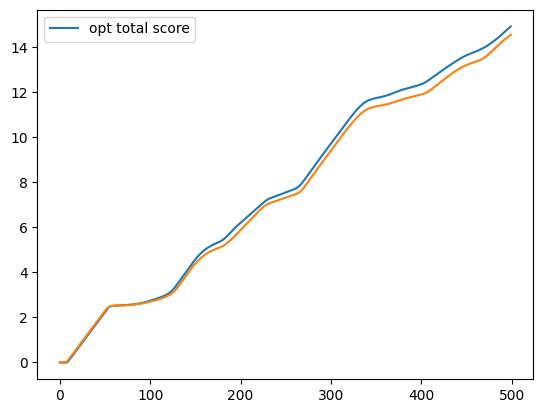

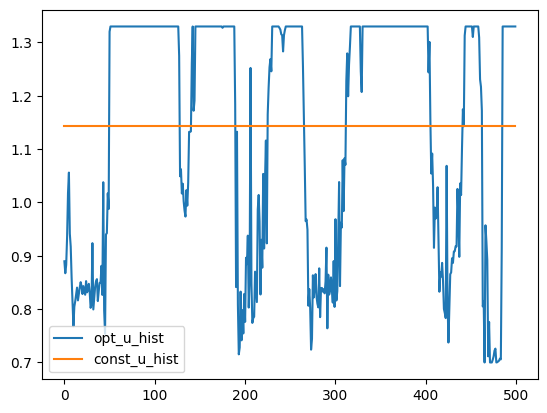

In [407]:
# loop through infeed array, at each step do the following:

# change first element of x to infeed
# solve for opt traj
# one_step_fwd with x and opt traj
# cash aht with x_next
C = controller_obj(master_sort_mat)
x_0=np.zeros((C.state_dim))
x_0[-1] = 1
x = np.zeros((C.state_dim))
x[-1] = 1
x_hist = np.zeros((log_time, C.state_dim))
opt_traj = np.ones((C.horizon))
score_hist = []
total_score_hist = []
total_score = 0
u_hist = []
speed_hist = []
_, master_sort_mat = C.rollout_linearize_A(x_0)
for i in tqdm(range(log_time)):
    x[:C.num_materials] = infeed[i]*0.15
    x_hist[i] = x
    
    traj_seed = opt_traj
    # traj_seed = np.ones((C.horizon)) * x[-1]
    opt_traj = C.solve_opt_traj(x, traj_seed)
    # opt_traj = np.ones((C.horizon)) * opt_mean
    x_new = C.one_step_fwd(x, opt_traj)
    # print('x new: ', x_new)
    step_score = C.cash_aht(x_new)
    # print('opt traj: ', opt_traj)
    # print('step score: ', step_score)
    
    
    score_hist.append(step_score)
    total_score += step_score
    total_score_hist.append(total_score)
    u_hist.append(opt_traj[0])
    
    x = x_new
plt.figure(1)
plt.plot(u_hist, label = 'opt_u_hist')
plt.figure(2)
plt.plot(total_score_hist, label = 'opt total score')


opt_mean = np.mean(u_hist)
x = np.zeros((C.state_dim))
x[-1] = 1
x_hist = np.zeros((log_time, C.state_dim))
opt_traj = np.ones((C.horizon))
score_hist = []
total_score_hist = []
total_score = 0
u_hist = []
speed_hist = []
for i in tqdm(range(log_time)):
    x[:C.num_materials] = infeed[i]*0.15
    x_hist[i] = x
    
    traj_seed = opt_traj
    # traj_seed = np.ones((C.horizon)) * x[-1]
    # opt_traj = C.solve_opt_traj(x, traj_seed)
    opt_traj = np.ones((C.horizon)) * opt_mean
    x_new = C.one_step_fwd(x, opt_traj)
    # print('x new: ', x_new)
    step_score = C.cash_aht(x_new)
    # print('opt traj: ', opt_traj)
    # print('step score: ', step_score)
    
    
    score_hist.append(step_score)
    total_score += step_score
    total_score_hist.append(total_score)
    u_hist.append(opt_traj[0])
    
    x = x_new
plt.figure(1)
plt.plot(u_hist, label = 'const_u_hist')
plt.figure(2)
plt.legend()
plt.plot(total_score_hist, label = 'const total score')
plt.figure(1)
plt.legend()



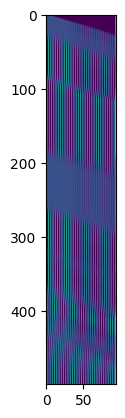

In [232]:
plt.imshow(x_hist)


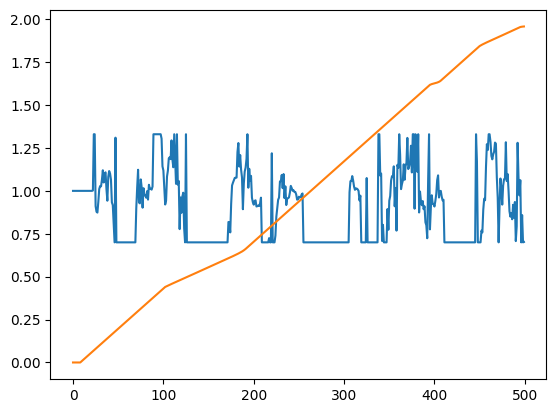

In [257]:
# plt.plot(np.array(opt_total_score_hist) - np.array(total_score_hist))
plt.plot(np.array(u_hist))
plt.plot(opt_total_score_hist)

In [206]:
speed_hist = []
for i in range(len(x_hist)):
    speed_hist.append(x_hist[i][-1])

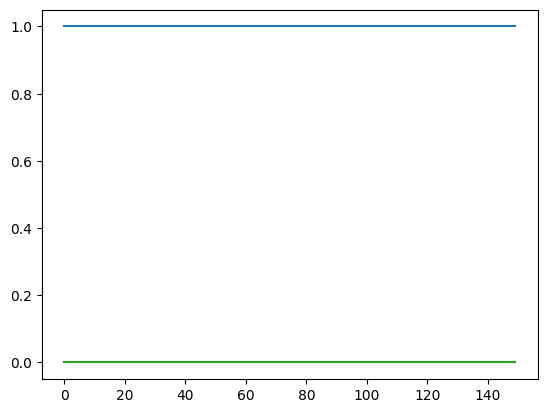

In [339]:
n_materials = 3

log_time = 150

infeed = np.ones((log_time, n_materials))

for i in range(log_time):
    infeed[:, 1] = 0
    infeed[:, 2] = 0
        
infeed *= 1

plt.plot(infeed[:, 0])
plt.plot(infeed[:, 1])
plt.plot(infeed[:, 2])

In [243]:
opt_mean = np.mean(u_hist)
opt_u_hist = u_hist
opt_score_hist = score_hist
opt_total_score_hist = total_score_hist

In [133]:
%matplotlib inline

In [18]:
thing = fake_sort @ C.prices

In [21]:
thing2 = np.random.rand(np.shape(thing)[0])

In [22]:
thing


array([0.306  , 0.306  , 0.124  , 0.124  , 0.01875, 0.01875])

In [23]:
thing2

array([0.68993023, 0.28092848, 0.8860834 , 0.35492936, 0.96978601,
       0.06894646])

In [25]:
thing @ thing2

0.4704445819750215

In [26]:
1 - thing

array([0.694  , 0.694  , 0.876  , 0.876  , 0.98125, 0.98125])